<a href="https://colab.research.google.com/github/zihan07/Research-of-Semantic-similarity-between-Quran-verses-with-Biographies/blob/mixed/Quran_verse_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -U sentence-transformers

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from matplotlib.ticker import PercentFormatter
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

# Load the Quran dataset
quran_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/quran-dataset_unlablled.xlsx'
quran_df = pd.read_excel(quran_file_path)

# Load the biography datasets (Mecca and Medina)
biography_makka_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Mecca'
biography_medina_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Medina'

# Load biography files as DataFrame
import os
import pandas as pd

def load_biographies(biography_path):
    """Loads all text files from a directory into a single DataFrame."""
    all_paragraphs = []
    for filename in os.listdir(biography_path):
        if filename.endswith(".txt"):  # Only read text files
            filepath = os.path.join(biography_path, filename)
            with open(filepath, 'r', encoding='utf-8') as file:
                paragraphs = file.read().splitlines()  # Read lines into a list
                all_paragraphs.extend(paragraphs)  # Add to the main list
    return pd.DataFrame(all_paragraphs, columns=['paragraph'])  # Create DataFrame

# Load biography files as DataFrame
biography_makka_df = load_biographies(biography_makka_path)
biography_medina_df = load_biographies(biography_medina_path)

display(pd.DataFrame(quran_df))

Mounted at /content/drive


,surah_no,verse_no,english_translation,Revelation_Period
0,1,1,"In the Name of Allah- the Most Compassionate, ...",undecided
1,1,2,"All praise is for Allah- Lord of all worlds,",undecided
2,1,3,"the Most Compassionate, Most Merciful,",undecided
3,1,4,Master of the Day of Judgment.,undecided
4,1,5,You alone we worship and You alone we ask for ...,undecided
...,...,...,...,...
6231,114,2,"the Master of humankind,",undecided
6232,114,3,"the God of humankind,",undecided
6233,114,4,from the evil of the lurking whisperer-,undecided
6234,114,5,who whispers into the hearts of humankind-,undecided


In [ ]:
display(pd.DataFrame(biography_makka_df))

,paragraph
0,Section Regarding the Prevention of the Jinn a...
1,
2,And Abu ‘Awanah reported on the authority of ‘...
3,
4,
...,...
900,
901,Ibn Ishaq related that Yazeed Ibn Abi Ziyad na...
902,
903,


In [ ]:
display(pd.DataFrame(biography_medina_df))

,paragraph
0,"The Fever of Madinah Afflicts the Muhajiroon, ..."
1,
2,"while he will be among his family, for death i..."
3,
4,It is recorded in the two saheehs that Ibn Abb...
...,...
439,
440,"There were four of them: Allah’s Messenger, Ab..."
441,
442,It has been previously mentioned from Ibn Abba...


Load the model and build the reference embedding space

In [ ]:
# Load a pre-trained sentence transformer model
model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Define a preprocessing function if needed (example: lowercasing)
def preprocess(text):
    return text.lower()

# Generate embeddings for each verse
quran_embeddings = model.encode(
    [preprocess(verse) for verse in quran_df['english_translation']],
    convert_to_tensor=True,
    show_progress_bar=True
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
# quran_embeddings now contains the tensor of embeddings for each verse
quran_df['embeddings'] = quran_embeddings.tolist()

# Save embeddings as a numpy file
np.save('quran_embeddings.npy', quran_embeddings.cpu().numpy())

quran_df.to_pickle('quran_with_embeddings.pkl')  # Save as a pickle file

Load the model and build the reference embedding space

In [ ]:
#read verse labels
labelpath = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/quran-dataset_unlablled.xlsx'
quran_labels_df= pd.read_excel(labelpath)

# Print the column names to verify
print(quran_labels_df.columns)

# Assuming the correct column name is 'Revelation Period' (adjust if needed)
labels_column = quran_labels_df['Revelation_Period']

quran_df = pd.concat([quran_df, labels_column.rename("revelation_period")], axis=1)
quran_df


Index(['surah_no', 'verse_no', 'english_translation', 'Revelation_Period'], dtype='object')


,surah_no,verse_no,english_translation,Revelation_Period,embeddings,revelation_period
0,1,1,"In the Name of Allah- the Most Compassionate, ...",undecided,"[0.029397880658507347, -0.05704449489712715, -...",undecided
1,1,2,"All praise is for Allah- Lord of all worlds,",undecided,"[-0.08603974431753159, -0.12181223183870316, -...",undecided
2,1,3,"the Most Compassionate, Most Merciful,",undecided,"[0.0888710543513298, 0.058305174112319946, 0.0...",undecided
3,1,4,Master of the Day of Judgment.,undecided,"[-0.0027960960287600756, 0.25249120593070984, ...",undecided
4,1,5,You alone we worship and You alone we ask for ...,undecided,"[0.17576298117637634, 0.24922874569892883, 0.0...",undecided
...,...,...,...,...,...,...
6231,114,2,"the Master of humankind,",undecided,"[0.06582338362932205, 0.2899615466594696, 0.01...",undecided
6232,114,3,"the God of humankind,",undecided,"[0.07240504026412964, 0.2638102173805237, 0.01...",undecided
6233,114,4,from the evil of the lurking whisperer-,undecided,"[0.12548843026161194, 0.2672560513019562, 0.00...",undecided
6234,114,5,who whispers into the hearts of humankind-,undecided,"[0.1792580932378769, 0.22346171736717224, -0.0...",undecided


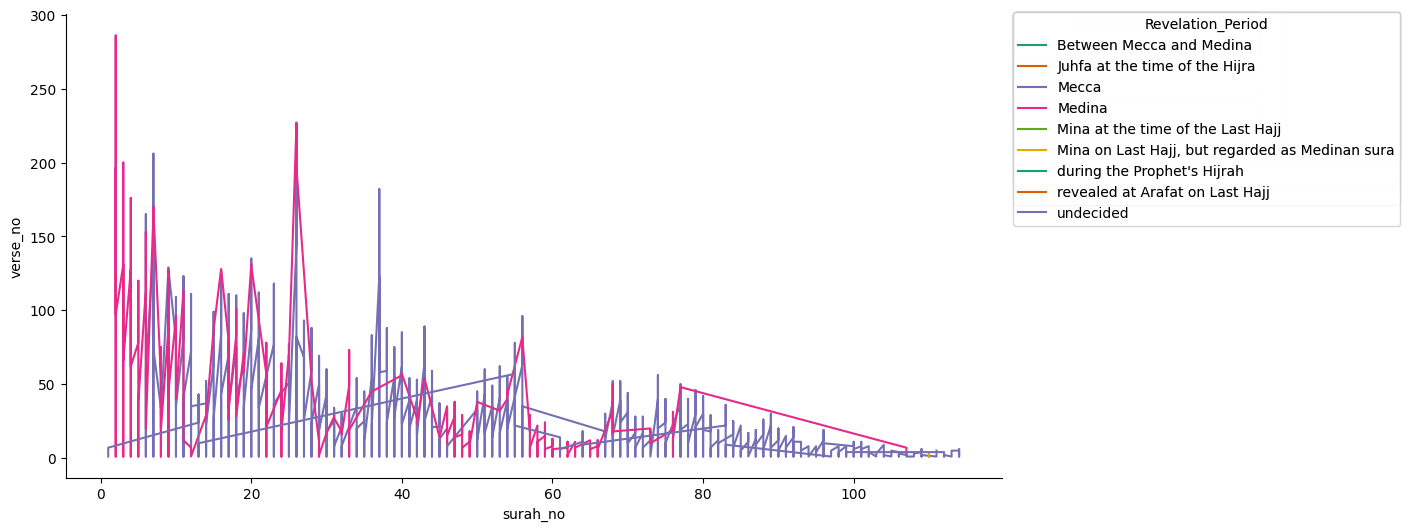

In [ ]:
# @title surah_no vs verse_no

# from matplotlib import pyplot as plt
# import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['surah_no']
  ys = series['verse_no']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = quran_df.sort_values('surah_no', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Revelation_Period')):
  _plot_series(series, series_name, i)
  fig.legend(title='Revelation_Period', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('surah_no')
_ = plt.ylabel('verse_no')

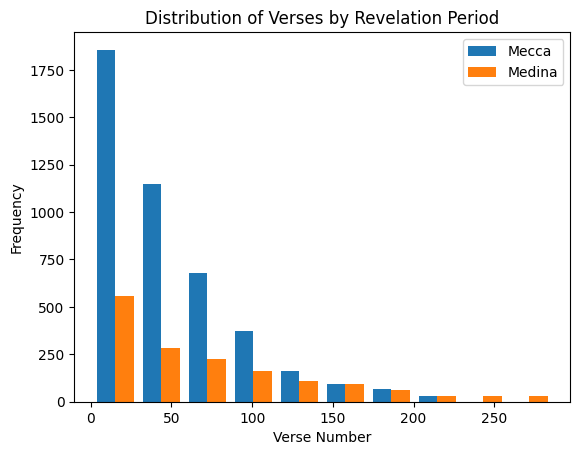

In [ ]:
# @title Distribution of Verses by Revelation Period

# import matplotlib.pyplot as plt

mecca_verses = quran_df[quran_df['Revelation_Period'] == 'Mecca']['verse_no']
medina_verses = quran_df[quran_df['Revelation_Period'] == 'Medina']['verse_no']

plt.hist([mecca_verses, medina_verses], label=['Mecca', 'Medina'])
plt.xlabel('Verse Number')
plt.ylabel('Frequency')
plt.title('Distribution of Verses by Revelation Period')
_ = plt.legend()

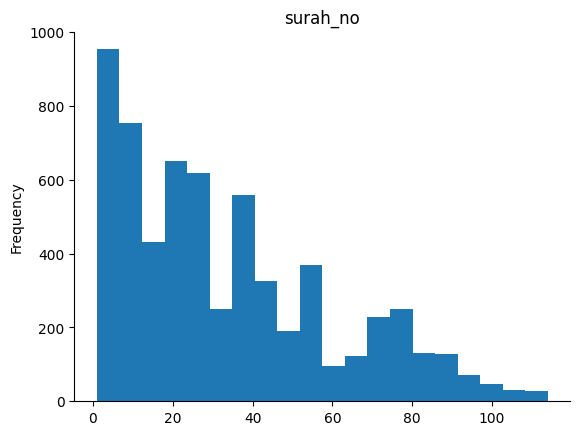

In [ ]:
# @title surah_no

# from matplotlib import pyplot as plt
quran_df['surah_no'].plot(kind='hist', bins=20, title='surah_no')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2') # replace the model name with any other sentence-transformers model

In [ ]:
def preprocess(sentence):
  """
    add preprocessing action as needed
  """
  return sentence.lower()

def transform_label(label):
  cor_label_names = {
      "Mecca" : 0,
      "Medina" : 1
  }
  return cor_label_names.get(label, None)

  topk = 1
def getMostProbablePred(df, simSentences, threshold = 0.4):
  predictions = []
  bestScorePerClass = dict()
  for x in simSentences:
    if x['score'] < threshold:
      return None
    pred = df['Revelation_Period'][x['corpus_id']]
    predictions.append(pred)
    if pred in bestScorePerClass:
      if bestScorePerClass[pred] < x['score']:
        bestScorePerClass[pred] = x['score']
    else:
      bestScorePerClass[pred] = x['score']
  counts = Counter(predictions)
  most_probable_pred, _ = counts.most_common(1)[0]
  return most_probable_pred, bestScorePerClass[most_probable_pred]

In [ ]:
quran_embeddings = model.encode([preprocess(quran_df['english_translation'][index]) for index in quran_df.index], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/195 [00:00<?, ?it/s]

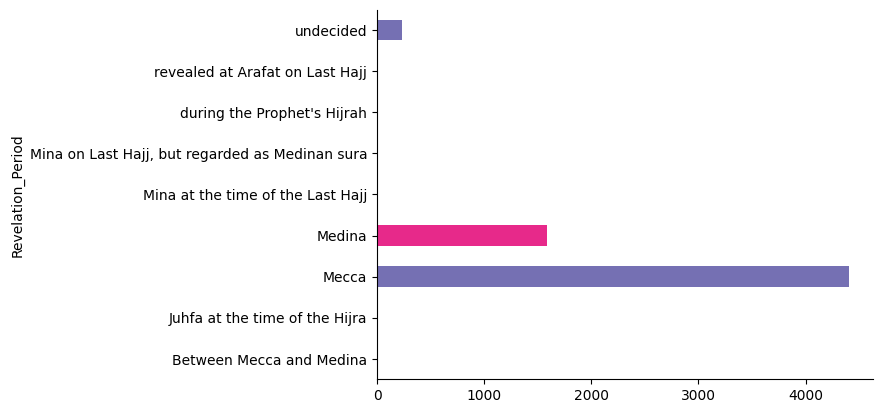

In [ ]:
#revelation_period
# from matplotlib import pyplot as plt
# import seaborn as sns
quran_df.groupby('Revelation_Period').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def predict_label(sentence, threshold=0.4):
  """
    Retrieves the most similar verse to the given sentence and returns it if the cosine-similarity
    between the sentence and the retrieved verse is more than the given threshold, else returns None
  """
  sentence_embedding = model.encode([sentence], convert_to_tensor=True, show_progress_bar=False)
  most_similar = util.semantic_search(sentence_embedding, quran_embeddings, top_k=topk)[0][0]
  if most_similar['score'] <= threshold:
    return None

In [ ]:
# import pandas as pd
# from tabulate import tabulate

# Load the Excel file
df = pd.read_excel(quran_file_path)
df['english_translation'] = df['english_translation'].apply(lambda x: x[:50] + '...' if len(x) > 50 else x)

df['Revelation_Period'] = df['Revelation_Period'].apply(lambda x: x[:50] + '...' if len(x) > 50 else x)
# Display the entire DataFrame as a table
print(tabulate(df, headers='keys', tablefmt='grid'))




+------+------------+------------+-------------------------------------------------------+-------------------------------------------------+
|      |   surah_no |   verse_no | english_translation                                   | Revelation_Period                               |
+======+============+============+=======================================================+=================================================+
|    0 |          1 |          1 | In the Name of Allah- the Most Compassionate, Most... | undecided                                       |
+------+------------+------------+-------------------------------------------------------+-------------------------------------------------+
|    1 |          1 |          2 | All praise is for Allah- Lord of all worlds,          | undecided                                       |
+------+------------+------------+-------------------------------------------------------+-------------------------------------------------+
|    2 |     

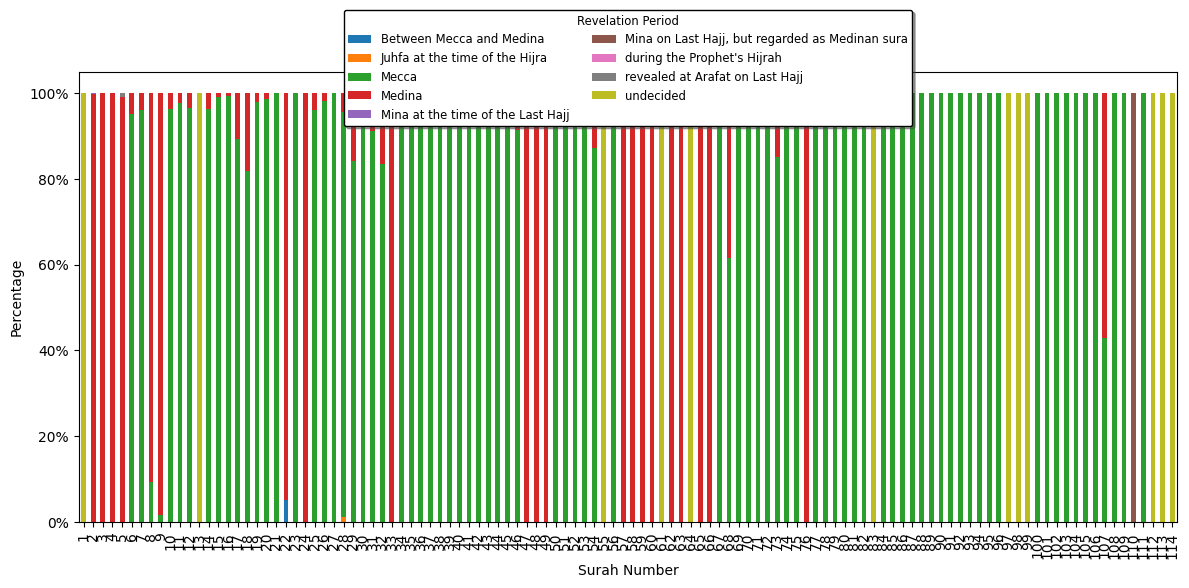

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import PercentFormatter

# Ensure 'surah_no' is numeric
df['surah_no'] = pd.to_numeric(df['surah_no'], errors='coerce')

# Group by 'surah_no' and calculate the percentage of Meccan and Medinan verses
surahStat = df.groupby('surah_no')['Revelation_Period'].value_counts(normalize=True).unstack().fillna(0) * 100

# Sort the data by 'surah_no'
surahStat = surahStat.sort_index()

# Plotting the stacked bar chart
ax = surahStat.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize the plot
ax.set_title(None)  # Remove the title
ax.legend(
    title='Revelation Period',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=2,
    fancybox=True,
    shadow=True,
    fontsize='small',
    title_fontsize='small',
    edgecolor='black',
    frameon=True
)
ax.set_xlabel('Surah Number')
ax.set_ylabel('Percentage')

# Format the y-axis to display percentages
ax.yaxis.set_major_formatter(PercentFormatter())

# Customize x-ticks
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
verse_numbers = df['verse_no'].tolist()

Paragraphing in dataset Valley Came Alive

In [ ]:
# import re
# import os

# Function to clean the text
def clean_text(text):
    # Remove extra spaces between words within paragraphs
    text = re.sub(r'[ ]{2,}', ' ', text)  # Replace multiple spaces with a single space

    # Remove line breaks within paragraphs to form complete lines
    text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)  # Merge lines within paragraphs

    # Ensure paragraphs are separated by two newlines
    text = re.sub(r'\n{2,}', '\n\n', text)  # Ensure double newlines between paragraphs

    return text

# Function to process all text files in a folder
def process_text_files(input_folder, output_folder):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all text files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.txt'):  # Process only .txt files
            file_path = os.path.join(input_folder, filename)

            # Read and clean the text
            with open(file_path, 'r', encoding='utf-8') as file:
                raw_text = file.read()
            cleaned_text = clean_text(raw_text)

            # Save the cleaned text to the output folder
            output_file_path = os.path.join(output_folder, filename)  # Save with the same filename
            with open(output_file_path, 'w', encoding='utf-8') as output_file:
                output_file.write(cleaned_text)

            print(f"Processed and saved: {output_file_path}")

# Specify the input folder containing the text files
input_folder = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive'  # Replace with the folder path containing your 20-25 text files

# Specify the output folder to save the cleaned text files
output_folder = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive'  # Replace with your desired output folder

# Process all text files in the folder
process_text_files(input_folder, output_folder)

print(f"All files processed and saved in {output_folder}")


All files processed and saved in /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive


# **Preprocessing**

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load the dataset
file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/quran-dataset_unlablled.xlsx'
df = pd.read_excel(file_path)

# Step 1: Clean and Organize Data
# Check for missing values and handle them
def check_missing_values(df):
    print("Missing values per column:\n", df.isnull().sum())

check_missing_values(df)

# Drop rows with missing `english_translation`
df = df.dropna(subset=['english_translation'])

# Standardize text: remove punctuation, lowercase text, and strip whitespace
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    return text

df['english_translation_cleaned'] = df['english_translation'].apply(clean_text)

# Step 2: Feature Engineering
# Extract text features
# Add a column for word count and character count
df['word_count'] = df['english_translation_cleaned'].apply(lambda x: len(x.split()))
df['char_count'] = df['english_translation_cleaned'].apply(len)

# Generate TF-IDF features
vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features
tfidf_matrix = vectorizer.fit_transform(df['english_translation_cleaned']).toarray()

# Convert TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix, columns=vectorizer.get_feature_names_out())

# Encode Revelation_Period if not "undecided"
def encode_revelation_period(row):
    if row == "undecided":
        return np.nan
    return row

df['Revelation_Period'] = df['Revelation_Period'].apply(encode_revelation_period)

# Encode categorical target variable
encoder = LabelEncoder()
df['Revelation_Period_Encoded'] = encoder.fit_transform(df['Revelation_Period'].fillna('Unknown'))

# Normalize numerical features
scaler = MinMaxScaler()
df[['surah_no', 'verse_no', 'word_count', 'char_count']] = scaler.fit_transform(
    df[['surah_no', 'verse_no', 'word_count', 'char_count']]
)

# Step 3: Splitting the Dataset
# Split into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 20% validation

# Combine the processed features into a single DataFrame
processed_df = pd.concat([
    df[['surah_no', 'verse_no', 'Revelation_Period_Encoded']],
    tfidf_df,
    df[['word_count', 'char_count']]
], axis=1)

# Save preprocessed datasets
train_df.to_csv('train_dataset.csv', index=False)
val_df.to_csv('val_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

# Final output
print("Preprocessing completed. Train, validation, and test datasets saved.")

Missing values per column:
 surah_no               0
verse_no               0
english_translation    0
Revelation_Period      0
dtype: int64
Preprocessing completed. Train, validation, and test datasets saved.


# **Biography Preprocessing**

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  # Download the 'punkt_tab' resource

# Step 1: Define folder paths for Mecca and Medina
mecca_folder = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Mecca'  # Path to the Mecca folder
medina_folder = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Medina'  # Path to the Medina folder

# Step 2: Function to read files from a folder and label them
def read_files_from_folder(folder_path, label):
    files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    texts = []
    labels = []

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)

        # Read the content of the text file
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            texts.append(text)
            labels.append(label)  # Assign the folder name (label) to each file

    return texts, labels

# Read files from both Mecca and Medina folders
mecca_texts, mecca_labels = read_files_from_folder(mecca_folder, 'Mecca')
medina_texts, medina_labels = read_files_from_folder(medina_folder, 'Medina')

# Combine both datasets (Mecca and Medina)
all_texts = mecca_texts + medina_texts
all_labels = mecca_labels + medina_labels

# Step 3: Create a DataFrame from the combined data
df = pd.DataFrame({
    'text': all_texts,
    'label': all_labels
})

# Show the first few rows of the dataset to understand its structure
print(df.head())

# Step 4: Handle missing values (if any)
df.dropna(inplace=True)

# Step 5: Preprocess Text Data
# Clean the text (remove unwanted characters, lowercase, etc.)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetical characters
    return text

df['text'] = df['text'].apply(clean_text)

# Tokenize text
def tokenize_text(text):
    return word_tokenize(text)

df['text'] = df['text'].apply(tokenize_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['text'] = df['text'].apply(remove_stopwords)

# Step 6: Convert Text Data into Numerical Features (Vectorization)
# Option 1: Count Vectorizer (Bag of Words)
vectorizer = CountVectorizer(analyzer=lambda x: x)  # Pass list of tokens directly to the vectorizer
X = vectorizer.fit_transform(df['text'])

# Option 2: TF-IDF Vectorizer (alternative to CountVectorizer)
# vectorizer = TfidfVectorizer(analyzer=lambda x: x)
# X = vectorizer.fit_transform(df['text'])

# Check the shape of the feature matrix
print(f"Feature Matrix Shape: {X.shape}")

# Step 7: Scale Numerical Features (if any)
# Check if there are any numerical features (for this example, we don't assume any)
numerical_features = df.select_dtypes(include=[np.number])

if not numerical_features.empty:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(numerical_features)
else:
    df_scaled = None

# Step 8: Split the Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Optional: If you have both text features and numerical features, combine them
# Example (if numerical features are present):
# if df_scaled is not None:
#     X_combined_train = np.hstack([X_train.toarray(), df_scaled[:len(X_train)]])
#     X_combined_test = np.hstack([X_test.toarray(), df_scaled[len(X_train):]])

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

# Now you're ready to apply machine learning models on X_train, X_test, y_train, y_test


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                text  label
0  Section Regarding the Prevention of the Jinn a...  Mecca
1  Mention of His Age at the Time When He Was Sen...  Mecca
2  Section Regarding How the Revelation Came to t...  Mecca
3  Chapter on How the Revelation Began to Come t...  Mecca
4  The Story of How Hamzah Ibn ‘Abdul Muttalib, t...  Mecca
Feature Matrix Shape: (56, 5437)
Training Features Shape: (44, 5437)
Testing Features Shape: (12, 5437)


Reading out The Valley came alive (Mecca Part)

# window **1**

In [ ]:
import os
import pandas as pd
import re

# Function to clean the text by removing extra spaces, blank lines, and redundant full stops
def clean_text(text):
    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove blank lines (lines that are empty or contain only whitespace)
    text = '\n'.join([line for line in text.split('\n') if line.strip()])

    # Remove redundant full stops (e.g., multiple full stops in a row)
    text = re.sub(r'\.{2,}', '.', text)

    # Ensure there is only one full stop at the end of the text (if any)
    text = re.sub(r'\.$', '', text)  # Remove trailing full stop
    text = text.strip() + '.' if text else ''  # Add a single full stop at the end

    return text

# Function to create frame paragraphs with biography data for a specified window size
def create_frame_paragraphs_with_bio_data(bio_folder_path, window_size=1):
    result = []

    # Iterate through each biography text file in the specified folder
    for filename in os.listdir(bio_folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            biography_name = os.path.splitext(filename)[0]  # Extract biography name from the filename
            file_path = os.path.join(bio_folder_path, filename)

            # Read the biography text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()  # Read the entire biography file as a single string

                # Clean the text (remove unwanted spaces, blank lines, and redundant full stops)
                cleaned_text = clean_text(text)

                # Split the cleaned text based on full stop and clean extra spaces
                sentences = [sentence.strip() for sentence in cleaned_text.split('.') if sentence.strip()]

                # Create sliding window paragraphs based on the specified window size
                for i in range(len(sentences) - (window_size - 1)):
                    # Combine sentences according to the window size into a paragraph
                    paragraph = ' '.join([sentence + '.' for sentence in sentences[i:i + window_size]])  # Add full stop back
                    line_range = f"{i + 1}-{i + window_size}"

                    result.append({
                        'Biography No': i + 1,
                        'Biography Name': biography_name,
                        'Line Range': line_range,
                        'Paragraph': paragraph
                    })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 1  # Adjust this value as needed

# Specify the path where your biography text files are located
bio_folder_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Mecca'  # Update this with your directory path

# Generate frame paragraphs with biography data using the specified window size
paragraphs_by_bio = create_frame_paragraphs_with_bio_data(bio_folder_path, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_bio)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame1.xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")


Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame1.xlsx


# **Window 2**

In [ ]:
import os
import pandas as pd
import re

# Function to clean the text by removing extra spaces, blank lines, and redundant full stops
def clean_text(text):
    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove blank lines (lines that are empty or contain only whitespace)
    text = '\n'.join([line for line in text.split('\n') if line.strip()])

    # Remove redundant full stops (e.g., multiple full stops in a row)
    text = re.sub(r'\.{2,}', '.', text)

    # Ensure there is only one full stop at the end of the text (if any)
    text = re.sub(r'\.$', '', text)  # Remove trailing full stop
    text = text.strip() + '.' if text else ''  # Add a single full stop at the end

    return text

# Function to create frame paragraphs with biography data for a specified window size
def create_frame_paragraphs_with_bio_data(bio_folder_path, window_size=2):
    result = []

    # Iterate through each biography text file in the specified folder
    for filename in os.listdir(bio_folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            biography_name = os.path.splitext(filename)[0]  # Extract biography name from the filename
            file_path = os.path.join(bio_folder_path, filename)

            # Read the biography text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()  # Read the entire biography file as a single string

                # Clean the text (remove unwanted spaces, blank lines, and redundant full stops)
                cleaned_text = clean_text(text)

                # Split the cleaned text based on full stop and clean extra spaces
                sentences = [sentence.strip() for sentence in cleaned_text.split('.') if sentence.strip()]

                # Create sliding window paragraphs based on the specified window size
                for i in range(len(sentences) - (window_size - 1)):
                    # Combine sentences according to the window size into a paragraph
                    paragraph = ' '.join([sentence + '.' for sentence in sentences[i:i + window_size]])  # Add full stop back
                    line_range = f"{i + 1}-{i + window_size}"

                    result.append({
                        'Biography No': i + 1,
                        'Biography Name': biography_name,
                        'Line Range': line_range,
                        'Paragraph': paragraph
                    })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 2  # Adjust this value as needed

# Specify the path where your biography text files are located
bio_folder_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Mecca'  # Update this with your directory path

# Generate frame paragraphs with biography data using the specified window size
paragraphs_by_bio = create_frame_paragraphs_with_bio_data(bio_folder_path, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_bio)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame2.xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")


Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame2.xlsx


# **Window 3**

In [ ]:
import os
import pandas as pd
import re

# Function to clean the text by removing extra spaces, blank lines, and redundant full stops
def clean_text(text):
    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove blank lines (lines that are empty or contain only whitespace)
    text = '\n'.join([line for line in text.split('\n') if line.strip()])

    # Remove redundant full stops (e.g., multiple full stops in a row)
    text = re.sub(r'\.{2,}', '.', text)

    # Ensure there is only one full stop at the end of the text (if any)
    text = re.sub(r'\.$', '', text)  # Remove trailing full stop
    text = text.strip() + '.' if text else ''  # Add a single full stop at the end

    return text

# Function to create frame paragraphs with biography data for a specified window size
def create_frame_paragraphs_with_bio_data(bio_folder_path, window_size=3):
    result = []

    # Iterate through each biography text file in the specified folder
    for filename in os.listdir(bio_folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            biography_name = os.path.splitext(filename)[0]  # Extract biography name from the filename
            file_path = os.path.join(bio_folder_path, filename)

            # Read the biography text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()  # Read the entire biography file as a single string

                # Clean the text (remove unwanted spaces, blank lines, and redundant full stops)
                cleaned_text = clean_text(text)

                # Split the cleaned text based on full stop and clean extra spaces
                sentences = [sentence.strip() for sentence in cleaned_text.split('.') if sentence.strip()]

                # Create sliding window paragraphs based on the specified window size
                for i in range(len(sentences) - (window_size - 1)):
                    # Combine sentences according to the window size into a paragraph
                    paragraph = ' '.join([sentence + '.' for sentence in sentences[i:i + window_size]])  # Add full stop back
                    line_range = f"{i + 1}-{i + window_size}"

                    result.append({
                        'Biography No': i + 1,
                        'Biography Name': biography_name,
                        'Line Range': line_range,
                        'Paragraph': paragraph
                    })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 3  # Adjust this value as needed

# Specify the path where your biography text files are located
bio_folder_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Mecca'  # Update this with your directory path

# Generate frame paragraphs with biography data using the specified window size
paragraphs_by_bio = create_frame_paragraphs_with_bio_data(bio_folder_path, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_bio)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame3.xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame3.xlsx


# **Window 4**

In [ ]:
import os
import pandas as pd
import re

# Function to clean the text by removing extra spaces, blank lines, and redundant full stops
def clean_text(text):
    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove blank lines (lines that are empty or contain only whitespace)
    text = '\n'.join([line for line in text.split('\n') if line.strip()])

    # Remove redundant full stops (e.g., multiple full stops in a row)
    text = re.sub(r'\.{2,}', '.', text)

    # Ensure there is only one full stop at the end of the text (if any)
    text = re.sub(r'\.$', '', text)  # Remove trailing full stop
    text = text.strip() + '.' if text else ''  # Add a single full stop at the end

    return text

# Function to create frame paragraphs with biography data for a specified window size
def create_frame_paragraphs_with_bio_data(bio_folder_path, window_size=4):
    result = []

    # Iterate through each biography text file in the specified folder
    for filename in os.listdir(bio_folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            biography_name = os.path.splitext(filename)[0]  # Extract biography name from the filename
            file_path = os.path.join(bio_folder_path, filename)

            # Read the biography text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()  # Read the entire biography file as a single string

                # Clean the text (remove unwanted spaces, blank lines, and redundant full stops)
                cleaned_text = clean_text(text)

                # Split the cleaned text based on full stop and clean extra spaces
                sentences = [sentence.strip() for sentence in cleaned_text.split('.') if sentence.strip()]

                # Create sliding window paragraphs based on the specified window size
                for i in range(len(sentences) - (window_size - 1)):
                    # Combine sentences according to the window size into a paragraph
                    paragraph = ' '.join([sentence + '.' for sentence in sentences[i:i + window_size]])  # Add full stop back
                    line_range = f"{i + 1}-{i + window_size}"

                    result.append({
                        'Biography No': i + 1,
                        'Biography Name': biography_name,
                        'Line Range': line_range,
                        'Paragraph': paragraph
                    })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 4  # Adjust this value as needed

# Specify the path where your biography text files are located
bio_folder_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Mecca'  # Update this with your directory path

# Generate frame paragraphs with biography data using the specified window size
paragraphs_by_bio = create_frame_paragraphs_with_bio_data(bio_folder_path, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_bio)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame4.xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame4.xlsx


# **Window 5**

In [ ]:
import os
import pandas as pd
import re

# Function to clean the text by removing extra spaces, blank lines, and redundant full stops
def clean_text(text):
    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove blank lines (lines that are empty or contain only whitespace)
    text = '\n'.join([line for line in text.split('\n') if line.strip()])

    # Remove redundant full stops (e.g., multiple full stops in a row)
    text = re.sub(r'\.{2,}', '.', text)

    # Ensure there is only one full stop at the end of the text (if any)
    text = re.sub(r'\.$', '', text)  # Remove trailing full stop
    text = text.strip() + '.' if text else ''  # Add a single full stop at the end

    return text

# Function to create frame paragraphs with biography data for a specified window size
def create_frame_paragraphs_with_bio_data(bio_folder_path, window_size=5):
    result = []

    # Iterate through each biography text file in the specified folder
    for filename in os.listdir(bio_folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            biography_name = os.path.splitext(filename)[0]  # Extract biography name from the filename
            file_path = os.path.join(bio_folder_path, filename)

            # Read the biography text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()  # Read the entire biography file as a single string

                # Clean the text (remove unwanted spaces, blank lines, and redundant full stops)
                cleaned_text = clean_text(text)

                # Split the cleaned text based on full stop and clean extra spaces
                sentences = [sentence.strip() for sentence in cleaned_text.split('.') if sentence.strip()]

                # Create sliding window paragraphs based on the specified window size
                for i in range(len(sentences) - (window_size - 1)):
                    # Combine sentences according to the window size into a paragraph
                    paragraph = ' '.join([sentence + '.' for sentence in sentences[i:i + window_size]])  # Add full stop back
                    line_range = f"{i + 1}-{i + window_size}"

                    result.append({
                        'Biography No': i + 1,
                        'Biography Name': biography_name,
                        'Line Range': line_range,
                        'Paragraph': paragraph
                    })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 5  # Adjust this value as needed

# Specify the path where your biography text files are located
bio_folder_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Mecca'  # Update this with your directory path

# Generate frame paragraphs with biography data using the specified window size
paragraphs_by_bio = create_frame_paragraphs_with_bio_data(bio_folder_path, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_bio)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame5.xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame5.xlsx


Reading out The Valley came alive (Madina Part)

# **Window 1**

In [ ]:
import os
import pandas as pd
import re

# Function to clean the text by removing extra spaces, blank lines, and redundant full stops
def clean_text(text):
    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove blank lines (lines that are empty or contain only whitespace)
    text = '\n'.join([line for line in text.split('\n') if line.strip()])

    # Remove redundant full stops (e.g., multiple full stops in a row)
    text = re.sub(r'\.{2,}', '.', text)

    # Ensure there is only one full stop at the end of the text (if any)
    text = re.sub(r'\.$', '', text)  # Remove trailing full stop
    text = text.strip() + '.' if text else ''  # Add a single full stop at the end

    return text

# Function to create frame paragraphs with biography data for a specified window size
def create_frame_paragraphs_with_bio_data(bio_folder_path, window_size=1):
    result = []

    # Iterate through each biography text file in the specified folder
    for filename in os.listdir(bio_folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            biography_name = os.path.splitext(filename)[0]  # Extract biography name from the filename
            file_path = os.path.join(bio_folder_path, filename)

            # Read the biography text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()  # Read the entire biography file as a single string

                # Clean the text (remove unwanted spaces, blank lines, and redundant full stops)
                cleaned_text = clean_text(text)

                # Split the cleaned text based on full stop and clean extra spaces
                sentences = [sentence.strip() for sentence in cleaned_text.split('.') if sentence.strip()]

                # Create sliding window paragraphs based on the specified window size
                for i in range(len(sentences) - (window_size - 1)):
                    # Combine sentences according to the window size into a paragraph
                    paragraph = ' '.join([sentence + '.' for sentence in sentences[i:i + window_size]])  # Add full stop back
                    line_range = f"{i + 1}-{i + window_size}"

                    result.append({
                        'Biography No': i + 1,
                        'Biography Name': biography_name,
                        'Line Range': line_range,
                        'Paragraph': paragraph
                    })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 1  # Adjust this value as needed

# Specify the path where your biography text files are located
bio_folder_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Medina'  # Update this with your directory path

# Generate frame paragraphs with biography data using the specified window size
paragraphs_by_bio = create_frame_paragraphs_with_bio_data(bio_folder_path, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_bio)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame1.xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame1.xlsx


**Window 2**

In [ ]:
import os
import pandas as pd
import re

# Function to clean the text by removing extra spaces, blank lines, and redundant full stops
def clean_text(text):
    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove blank lines (lines that are empty or contain only whitespace)
    text = '\n'.join([line for line in text.split('\n') if line.strip()])

    # Remove redundant full stops (e.g., multiple full stops in a row)
    text = re.sub(r'\.{2,}', '.', text)

    # Ensure there is only one full stop at the end of the text (if any)
    text = re.sub(r'\.$', '', text)  # Remove trailing full stop
    text = text.strip() + '.' if text else ''  # Add a single full stop at the end

    return text

# Function to create frame paragraphs with biography data for a specified window size
def create_frame_paragraphs_with_bio_data(bio_folder_path, window_size=2):
    result = []

    # Iterate through each biography text file in the specified folder
    for filename in os.listdir(bio_folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            biography_name = os.path.splitext(filename)[0]  # Extract biography name from the filename
            file_path = os.path.join(bio_folder_path, filename)

            # Read the biography text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()  # Read the entire biography file as a single string

                # Clean the text (remove unwanted spaces, blank lines, and redundant full stops)
                cleaned_text = clean_text(text)

                # Split the cleaned text based on full stop and clean extra spaces
                sentences = [sentence.strip() for sentence in cleaned_text.split('.') if sentence.strip()]

                # Create sliding window paragraphs based on the specified window size
                for i in range(len(sentences) - (window_size - 1)):
                    # Combine sentences according to the window size into a paragraph
                    paragraph = ' '.join([sentence + '.' for sentence in sentences[i:i + window_size]])  # Add full stop back
                    line_range = f"{i + 1}-{i + window_size}"

                    result.append({
                        'Biography No': i + 1,
                        'Biography Name': biography_name,
                        'Line Range': line_range,
                        'Paragraph': paragraph
                    })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 2  # Adjust this value as needed

# Specify the path where your biography text files are located
bio_folder_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Medina'  # Update this with your directory path

# Generate frame paragraphs with biography data using the specified window size
paragraphs_by_bio = create_frame_paragraphs_with_bio_data(bio_folder_path, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_bio)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame2.xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame2.xlsx


**Window 3**

In [ ]:
import os
import pandas as pd
import re

# Function to clean the text by removing extra spaces, blank lines, and redundant full stops
def clean_text(text):
    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove blank lines (lines that are empty or contain only whitespace)
    text = '\n'.join([line for line in text.split('\n') if line.strip()])

    # Remove redundant full stops (e.g., multiple full stops in a row)
    text = re.sub(r'\.{2,}', '.', text)

    # Ensure there is only one full stop at the end of the text (if any)
    text = re.sub(r'\.$', '', text)  # Remove trailing full stop
    text = text.strip() + '.' if text else ''  # Add a single full stop at the end

    return text

# Function to create frame paragraphs with biography data for a specified window size
def create_frame_paragraphs_with_bio_data(bio_folder_path, window_size=3):
    result = []

    # Iterate through each biography text file in the specified folder
    for filename in os.listdir(bio_folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            biography_name = os.path.splitext(filename)[0]  # Extract biography name from the filename
            file_path = os.path.join(bio_folder_path, filename)

            # Read the biography text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()  # Read the entire biography file as a single string

                # Clean the text (remove unwanted spaces, blank lines, and redundant full stops)
                cleaned_text = clean_text(text)

                # Split the cleaned text based on full stop and clean extra spaces
                sentences = [sentence.strip() for sentence in cleaned_text.split('.') if sentence.strip()]

                # Create sliding window paragraphs based on the specified window size
                for i in range(len(sentences) - (window_size - 1)):
                    # Combine sentences according to the window size into a paragraph
                    paragraph = ' '.join([sentence + '.' for sentence in sentences[i:i + window_size]])  # Add full stop back
                    line_range = f"{i + 1}-{i + window_size}"

                    result.append({
                        'Biography No': i + 1,
                        'Biography Name': biography_name,
                        'Line Range': line_range,
                        'Paragraph': paragraph
                    })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 3  # Adjust this value as needed

# Specify the path where your biography text files are located
bio_folder_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Medina'  # Update this with your directory path

# Generate frame paragraphs with biography data using the specified window size
paragraphs_by_bio = create_frame_paragraphs_with_bio_data(bio_folder_path, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_bio)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame3.xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame3.xlsx


**Window 4**

In [ ]:
import os
import pandas as pd
import re

# Function to clean the text by removing extra spaces, blank lines, and redundant full stops
def clean_text(text):
    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove blank lines (lines that are empty or contain only whitespace)
    text = '\n'.join([line for line in text.split('\n') if line.strip()])

    # Remove redundant full stops (e.g., multiple full stops in a row)
    text = re.sub(r'\.{2,}', '.', text)

    # Ensure there is only one full stop at the end of the text (if any)
    text = re.sub(r'\.$', '', text)  # Remove trailing full stop
    text = text.strip() + '.' if text else ''  # Add a single full stop at the end

    return text

# Function to create frame paragraphs with biography data for a specified window size
def create_frame_paragraphs_with_bio_data(bio_folder_path, window_size=4):
    result = []

    # Iterate through each biography text file in the specified folder
    for filename in os.listdir(bio_folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            biography_name = os.path.splitext(filename)[0]  # Extract biography name from the filename
            file_path = os.path.join(bio_folder_path, filename)

            # Read the biography text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()  # Read the entire biography file as a single string

                # Clean the text (remove unwanted spaces, blank lines, and redundant full stops)
                cleaned_text = clean_text(text)

                # Split the cleaned text based on full stop and clean extra spaces
                sentences = [sentence.strip() for sentence in cleaned_text.split('.') if sentence.strip()]

                # Create sliding window paragraphs based on the specified window size
                for i in range(len(sentences) - (window_size - 1)):
                    # Combine sentences according to the window size into a paragraph
                    paragraph = ' '.join([sentence + '.' for sentence in sentences[i:i + window_size]])  # Add full stop back
                    line_range = f"{i + 1}-{i + window_size}"

                    result.append({
                        'Biography No': i + 1,
                        'Biography Name': biography_name,
                        'Line Range': line_range,
                        'Paragraph': paragraph
                    })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 4  # Adjust this value as needed

# Specify the path where your biography text files are located
bio_folder_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Medina'  # Update this with your directory path

# Generate frame paragraphs with biography data using the specified window size
paragraphs_by_bio = create_frame_paragraphs_with_bio_data(bio_folder_path, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_bio)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame4.xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame4.xlsx


**Window 5**

In [ ]:
import os
import pandas as pd
import re

# Function to clean the text by removing extra spaces, blank lines, and redundant full stops
def clean_text(text):
    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove blank lines (lines that are empty or contain only whitespace)
    text = '\n'.join([line for line in text.split('\n') if line.strip()])

    # Remove redundant full stops (e.g., multiple full stops in a row)
    text = re.sub(r'\.{2,}', '.', text)

    # Ensure there is only one full stop at the end of the text (if any)
    text = re.sub(r'\.$', '', text)  # Remove trailing full stop
    text = text.strip() + '.' if text else ''  # Add a single full stop at the end

    return text

# Function to create frame paragraphs with biography data for a specified window size
def create_frame_paragraphs_with_bio_data(bio_folder_path, window_size=5):
    result = []

    # Iterate through each biography text file in the specified folder
    for filename in os.listdir(bio_folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            biography_name = os.path.splitext(filename)[0]  # Extract biography name from the filename
            file_path = os.path.join(bio_folder_path, filename)

            # Read the biography text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()  # Read the entire biography file as a single string

                # Clean the text (remove unwanted spaces, blank lines, and redundant full stops)
                cleaned_text = clean_text(text)

                # Split the cleaned text based on full stop and clean extra spaces
                sentences = [sentence.strip() for sentence in cleaned_text.split('.') if sentence.strip()]

                # Create sliding window paragraphs based on the specified window size
                for i in range(len(sentences) - (window_size - 1)):
                    # Combine sentences according to the window size into a paragraph
                    paragraph = ' '.join([sentence + '.' for sentence in sentences[i:i + window_size]])  # Add full stop back
                    line_range = f"{i + 1}-{i + window_size}"

                    result.append({
                        'Biography No': i + 1,
                        'Biography Name': biography_name,
                        'Line Range': line_range,
                        'Paragraph': paragraph
                    })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 5  # Adjust this value as needed

# Specify the path where your biography text files are located
bio_folder_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/The Valley Came Alive/Medina'  # Update this with your directory path

# Generate frame paragraphs with biography data using the specified window size
paragraphs_by_bio = create_frame_paragraphs_with_bio_data(bio_folder_path, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_bio)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame5.xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame5.xlsx


**DATA FRAME  **1** **

In [ ]:
# import pandas as pd

# Load the Quran dataset
file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/quran-dataset_unlablled.xlsx'  # Update this with your dataset path
quran_df = pd.read_excel(file_path)

# Function to create frame paragraphs with revelation period for a specified window size
def create_frame_paragraphs_with_period(df, window_size=1):
    result = []

    # Iterate through each surah from 1 to 114
    for surah_no in range(1, 115):
        # Filter the DataFrame for the current surah_no
        group = df[df['surah_no'] == surah_no]

        if not group.empty:
            group = group.sort_values(by='verse_no')  # Ensure verses are sorted by verse_no

            # Get the verses, verse numbers, and revelation period for the current surah
            verses = group['english_translation'].tolist()
            verse_numbers = group['verse_no'].tolist()
            revelation_periods = group['Revelation_Period'].tolist()

            # Create sliding window paragraphs based on the specified window size
            for i in range(len(verses) - (window_size - 1)):
                # Combine verses according to the window size into a paragraph
                paragraph = ' '.join(verses[i:i + window_size])
                verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}"

                # Determine the revelation period for the current range
                period_window = revelation_periods[i:i + window_size]
                if all(period == period_window[0] for period in period_window):
                    Revelation_Period = period_window[0]  # Consistent period (either Makka or Medina)
                else:
                    Revelation_Period = "Mixed"  # Mixed revelation periods

                result.append({
                    'Surah No': surah_no,
                    'Verse Range': verse_range,
                    'Paragraph': paragraph,
                    'Revelation Period': Revelation_Period
                })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 1  # Adjust this value as needed

# Generate frame paragraphs with revelation period using the specified window size
paragraphs_by_surah = create_frame_paragraphs_with_period(quran_df, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_surah)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D1 (1-2,2-3...and so on)(1).xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D1 (1-2,2-3...and so on)(1).xlsx


In [ ]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import re

# Load the Quran dataset
quran_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D1 (1-2,2-3...and so on)(1).xlsx'
quran_df = pd.read_excel(quran_file_path)

# Load the biography datasets (Mecca and Medina)
biography_makka_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/mecca_VCA_windowFrame1.xlsx'
biography_medina_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/medina_VCA_windowFrame1.xlsx'

# Load biography files as DataFrame
biography_makka_df = pd.read_excel(biography_makka_path, header=None, names=['paragraph'])
biography_medina_df = pd.read_excel(biography_medina_path, header=None, names=['paragraph'])

# Reset the index to a simple RangeIndex before adding 1
biography_makka_df = biography_makka_df.reset_index(drop=True)
biography_medina_df = biography_medina_df.reset_index(drop=True)

# Add 'Biography Number' to identify paragraphs
biography_makka_df['Biography No'] = biography_makka_df.index + 1
biography_medina_df['Biography No'] = biography_medina_df.index + 1

# Combine the biography datasets into a single DataFrame with a 'Revelation_Period' column
biography_makka_df['Revelation_Period'] = 'Mecca'
biography_medina_df['Revelation_Period'] = 'Medina'
biography_df = pd.concat([biography_makka_df, biography_medina_df], ignore_index=True)

# Load the pre-trained SentenceTransformer model
model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Function to infer relationship based on keywords in both verse and best match line
def infer_relationship(verse, biography_line):
    if 'battle' in verse.lower() or 'battle' in biography_line.lower():
        return 'Historical Context (Battle)'
    elif 'believe' in verse.lower() or 'faith' in biography_line.lower():
        return 'Spiritual Guidance'
    elif 'prophet' in verse.lower() or 'messenger' in biography_line.lower():
        return 'Prophetic Actions'
    elif 'law' in verse.lower() or 'command' in biography_line.lower():
        return 'Legal/Instructional'
    elif 'community' in verse.lower() or 'ummah' in biography_line.lower():
        return 'Community Impact'
    else:
        return 'General Contextual Relationship'

# Function to clean text for Excel compatibility
def clean_text_for_excel(text):
    return re.sub(r'[\x00-\x09\x0b-\x1f\x7f-\x9f]', '', text)

# Function for enhanced similarity and prediction
def find_best_similarity_with_biography(quran_df, biography_df, window_size=1, threshold=0.4, top_n=1):
    results = []

    # Changed 'Surah_no' to 'Surah No' to match the column name in quran_df
    surah_numbers = quran_df['Surah No'].tolist()
    # Access the 'Verse Range' column and extract the starting verse number
    verse_numbers = [int(verse_range.split('-')[0]) for verse_range in quran_df['Verse Range'].tolist()]
    # Changed 'english_translation' to 'Paragraph' to match the column name
    verses = quran_df['Paragraph'].tolist()
    periods = quran_df['Revelation Period'].tolist()  # Changed column name

    verse_embeddings = model.encode(verses, convert_to_tensor=True)
    biography_texts = biography_df['paragraph'].tolist()
    biography_periods = biography_df['Revelation_Period'].tolist()
    biography_lines = biography_df['Biography No'].tolist()
    biography_embeddings = model.encode(biography_texts, convert_to_tensor=True)

    for i in range(len(verses) - window_size + 1):
        verse_frame = ' '.join(verses[i:i + window_size])
        verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}" # This line needs to be updated as well to use the new verse_numbers
        actual_period = periods[i]

        frame_embedding = model.encode(verse_frame, convert_to_tensor=True)
        similarity_scores = util.pytorch_cos_sim(frame_embedding, biography_embeddings)[0]

        top_indices = similarity_scores.topk(top_n).indices
        top_scores = similarity_scores[top_indices].tolist()

        # Calculate the best match line and its associated properties
        best_match_idx = top_indices[0].item()
        best_match_line = biography_texts[best_match_idx]
        best_match_score = top_scores[0]
        assigned_biography = biography_periods[best_match_idx]
        best_biography_line = biography_lines[best_match_idx]  # Get the biography number

        # Infer the relationship between the verse and the biography
        relationship = infer_relationship(verse_frame, best_match_line)

        # Calculate Biography Line Range (based on top N lines)
        biography_line_range = f"{biography_lines[top_indices[0]]}-{biography_lines[top_indices[-1]]}"

        # Append results
        results.append({
            'Surah No': surah_numbers[i],  # Use 'Surah No' here as well
            'Verse Range': verse_range,
            'Verse (as Window Frame)': clean_text_for_excel(verse_frame),
            'Actual Period': actual_period,
            'Predicted Period': assigned_biography,
            'Best Match Line': clean_text_for_excel(best_match_line),
            'Best Match Score (as percentage)': round(best_match_score * 100, 2),
            'Assigned Biography': assigned_biography,
            'Biography line no': best_biography_line,
            'Biography Line Range': biography_line_range,  # New column for biography line range
            'Biography Name': best_biography_line,  # New column for biography name (i.e., Biography No)
            'Relationship': relationship
        })

    return results

# Generate the similarity results with improved accuracy
similarity_results = find_best_similarity_with_biography(quran_df, biography_df)
results_df = pd.DataFrame(similarity_results)

# Save results to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/v1 b1 k1.xlsx'
results_df.to_excel(output_file_path, index=False)

print(f"Optimized similarity results saved to {output_file_path}")

Optimized similarity results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/v1 b1 k1.xlsx


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import re

# Load the Quran dataset
quran_file_path = '/mnt/data/D1 (1-2,2-3...and so on)(1).xlsx'
quran_df = pd.read_excel(quran_file_path)

# Load the biography datasets (Mecca and Medina) assuming they already contain necessary columns
biography_makka_path = '/mnt/data/mecca_VCA_windowFrame1.xlsx'
biography_medina_path = '/mnt/data/medina_VCA_windowFrame1.xlsx'

biography_makka_df = pd.read_excel(biography_makka_path)
biography_medina_df = pd.read_excel(biography_medina_path)

# Combine the biography datasets into a single DataFrame
biography_df = pd.concat([biography_makka_df, biography_medina_df], ignore_index=True)

# Load the pre-trained SentenceTransformer model
model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Function to infer relationship based on keywords in both verse and best match line
def infer_relationship(verse, biography_line):
    if 'battle' in verse.lower() or 'battle' in biography_line.lower():
        return 'Historical Context (Battle)'
    elif 'believe' in verse.lower() or 'faith' in biography_line.lower():
        return 'Spiritual Guidance'
    elif 'prophet' in verse.lower() or 'messenger' in biography_line.lower():
        return 'Prophetic Actions'
    elif 'law' in verse.lower() or 'command' in biography_line.lower():
        return 'Legal/Instructional'
    elif 'community' in verse.lower() or 'ummah' in biography_line.lower():
        return 'Community Impact'
    else:
        return 'General Contextual Relationship'

# Function to clean text for Excel compatibility
def clean_text_for_excel(text):
    return re.sub(r'[\x00-\x09\x0b-\x1f\x7f-\x9f]', '', text)

# Function for enhanced similarity and prediction
def find_best_similarity_with_biography(quran_df, biography_df, window_size=1, threshold=0.4, top_n=1):
    results = []

    surah_numbers = quran_df['surah_no'].tolist()
    verse_numbers = quran_df['verse_no'].tolist()
    verses = quran_df['english_translation'].tolist()
    periods = quran_df['Revelation_Period'].tolist()

    verse_embeddings = model.encode(verses, convert_to_tensor=True)
    biography_texts = biography_df['paragraph'].tolist()
    biography_periods = biography_df['Revelation_Period'].tolist()
    biography_lines = biography_df['Biography No'].tolist()
    biography_names = biography_df['Biography Name'].tolist()
    biography_embeddings = model.encode(biography_texts, convert_to_tensor=True)

    for i in range(len(verses) - window_size + 1):
        verse_frame = ' '.join(verses[i:i + window_size])
        verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}"
        actual_period = periods[i]

        frame_embedding = model.encode(verse_frame, convert_to_tensor=True)
        similarity_scores = util.pytorch_cos_sim(frame_embedding, biography_embeddings)[0]

        top_indices = similarity_scores.topk(top_n).indices
        top_scores = similarity_scores[top_indices].tolist()

        # Calculate the best match line and its associated properties
        best_match_idx = top_indices[0].item()
        best_match_line = biography_texts[best_match_idx]
        best_match_score = top_scores[0]
        assigned_biography = biography_periods[best_match_idx]
        best_biography_line = biography_lines[best_match_idx]
        best_biography_name = biography_names[best_match_idx]

        # Infer the relationship between the verse and the biography
        relationship = infer_relationship(verse_frame, best_match_line)

        # Calculate Biography Line Range (based on top N lines)
        biography_line_range = f"{biography_lines[top_indices[0]]}-{biography_lines[top_indices[-1]]}"

        # Append results
        results.append({
            'Surah No': surah_numbers[i],
            'Verse Range': verse_range,
            'Verse (as Window Frame)': clean_text_for_excel(verse_frame),
            'Actual Period': actual_period,
            'Predicted Period': assigned_biography,
            'Best Match Line': clean_text_for_excel(best_match_line),
            'Best Match Score (as percentage)': round(best_match_score * 100, 2),
            'Assigned Biography': assigned_biography,
            'Biography line no': best_biography_line,
            'Biography Line Range': biography_line_range,
            'Biography Name': best_biography_name,
            'Relationship': relationship
        })

    return results

# Generate the similarity results with improved accuracy
similarity_results = find_best_similarity_with_biography(quran_df, biography_df)
results_df = pd.DataFrame(similarity_results)

# Save results to an Excel file
output_file_path = '/mnt/data/v1_b1_k1.xlsx'
results_df.to_excel(output_file_path, index=False)

output_file_path

**DATA FRAME  **2** **

In [ ]:
# # import pandas as pd

# # Load the Quran dataset
# file_path = '/content/drive/MyDrive/CSE498R/quran-dataset.xlsx'  # Update this with your dataset path
# quran_df = pd.read_excel(file_path)

# Function to create frame paragraphs with revelation period for a specified window size
def create_frame_paragraphs_with_period(df, window_size=2):
    result = []

    # Iterate through each surah from 1 to 114
    for surah_no in range(1, 115):
        # Filter the DataFrame for the current surah_no
        group = df[df['surah_no'] == surah_no]

        if not group.empty:
            group = group.sort_values(by='verse_no')  # Ensure verses are sorted by verse_no

            # Get the verses, verse numbers, and revelation period for the current surah
            verses = group['english_translation'].tolist()
            verse_numbers = group['verse_no'].tolist()
            revelation_periods = group['Revelation_Period'].tolist()

            # Create sliding window paragraphs based on the specified window size
            for i in range(len(verses) - (window_size - 1)):
                # Combine verses according to the window size into a paragraph
                paragraph = ' '.join(verses[i:i + window_size])
                verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}"

                # Determine the revelation period for the current range
                period_window = revelation_periods[i:i + window_size]
                if all(period == period_window[0] for period in period_window):
                    Revelation_Period = period_window[0]  # Consistent period (either Makka or Medina)
                else:
                    Revelation_Period = "Mixed"  # Mixed revelation periods

                result.append({
                    'Surah No': surah_no,
                    'Verse Range': verse_range,
                    'Paragraph': paragraph,
                    'Revelation Period': Revelation_Period
                })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 2  # Adjust this value as needed

# Generate frame paragraphs with revelation period using the specified window size
paragraphs_by_surah = create_frame_paragraphs_with_period(quran_df, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_surah)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D2 (1-3,2-4 and so on)(2).xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D2 (1-3,2-4 and so on)(2).xlsx


In [ ]:
# import os
# import pandas as pd
# from sentence_transformers import SentenceTransformer, util
# import re

# # Load the Quran dataset
# quran_file_path = '/content/drive/MyDrive/CSE498R/quran-dataset.xlsx'
# quran_df = pd.read_excel(quran_file_path)

# # Load the biography datasets (Mecca and Medina)
# biography_makka_path = '/content/drive/MyDrive/CSE498R/The Valley Came Alive/Mecca/Mecca-1.txt'
# biography_medina_path = '/content/drive/MyDrive/CSE498R/The Valley Came Alive/Medina/Medina-1.txt'

# # Load biography files as DataFrame
# biography_makka_df = pd.read_csv(biography_makka_path, sep='\t', header=None, names=['paragraph'])
# biography_medina_df = pd.read_csv(biography_medina_path, sep='\t', header=None, names=['paragraph'])

# Add 'Biography Number' to identify paragraphs
biography_makka_df['Biography No'] = biography_makka_df.index + 1
biography_medina_df['Biography No'] = biography_medina_df.index + 1

# Combine the biography datasets into a single DataFrame with a 'Revelation_Period' column
biography_makka_df['Revelation_Period'] = 'Mecca'
biography_medina_df['Revelation_Period'] = 'Medina'
biography_df = pd.concat([biography_makka_df, biography_medina_df], ignore_index=True)

# Load the pre-trained SentenceTransformer model
model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Function to infer relationship based on keywords in both verse and best match line
def infer_relationship(verse, biography_line):
    if 'battle' in verse.lower() or 'battle' in biography_line.lower():
        return 'Historical Context (Battle)'
    elif 'believe' in verse.lower() or 'faith' in biography_line.lower():
        return 'Spiritual Guidance'
    elif 'prophet' in verse.lower() or 'messenger' in biography_line.lower():
        return 'Prophetic Actions'
    elif 'law' in verse.lower() or 'command' in biography_line.lower():
        return 'Legal/Instructional'
    elif 'community' in verse.lower() or 'ummah' in biography_line.lower():
        return 'Community Impact'
    else:
        return 'General Contextual Relationship'

# Function to clean text for Excel compatibility
def clean_text_for_excel(text):
    return re.sub(r'[\x00-\x09\x0b-\x1f\x7f-\x9f]', '', text)

# Function for enhanced similarity and prediction
def find_best_similarity_with_biography(quran_df, biography_df, window_size=2, threshold=0.4, top_n=5):
    results = []

    surah_numbers = quran_df['surah_no'].tolist()
    verse_numbers = quran_df['verse_no'].tolist()
    verses = quran_df['english_translation'].tolist()
    periods = quran_df['Revelation_Period'].tolist()

    verse_embeddings = model.encode(verses, convert_to_tensor=True)
    biography_texts = biography_df['paragraph'].tolist()
    biography_periods = biography_df['Revelation_Period'].tolist()
    biography_lines = biography_df['Biography No'].tolist()
    biography_embeddings = model.encode(biography_texts, convert_to_tensor=True)

    for i in range(len(verses) - window_size + 1):
        verse_frame = ' '.join(verses[i:i + window_size])
        verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}"
        actual_period = periods[i]

        frame_embedding = model.encode(verse_frame, convert_to_tensor=True)
        similarity_scores = util.pytorch_cos_sim(frame_embedding, biography_embeddings)[0]

        top_indices = similarity_scores.topk(top_n).indices
        top_scores = similarity_scores[top_indices].tolist()

        # Retrieve scores for Mecca and Medina
        mecca_score, medina_score = 0, 0
        mecca_count, medina_count = 0, 0
        for idx, score in zip(top_indices, top_scores):
            if score < threshold:
                continue
            if biography_periods[idx] == 'Mecca':
                mecca_score += score
                mecca_count += 1
            else:
                medina_score += score
                medina_count += 1

        if mecca_score > medina_score:
            predicted_period = 'Mecca'
        elif medina_score > mecca_score:
            predicted_period = 'Medina'
        else:
            predicted_period = 'Uncertain'

        # Calculate the best match line and its associated properties
        best_match_idx = top_indices[0].item()
        best_match_line = biography_texts[best_match_idx]
        best_match_score = top_scores[0]
        assigned_biography = biography_periods[best_match_idx]
        best_biography_line = biography_lines[best_match_idx]  # Get the biography number

        # Infer the relationship between the verse and the biography
        relationship = infer_relationship(verse_frame, best_match_line)

        # Append results
        results.append({
            'Surah No': surah_numbers[i],
            'Verse Range': verse_range,
            'Verse (as Window Frame)': clean_text_for_excel(verse_frame),
            'Actual Period': actual_period,
            'Predicted Period': predicted_period,
            'Best Match Line': clean_text_for_excel(best_match_line),
            'Best Match Score (as percentage)': round(best_match_score * 100, 2),
            'Mecca Similarity': round(mecca_score, 4),
            'Medina Similarity': round(medina_score, 4),
            'Assigned Biography': assigned_biography,
            'Biography line no': best_biography_line,
            'Relationship': relationship
        })

    return results

# Generate the similarity results with improved accuracy
similarity_results = find_best_similarity_with_biography(quran_df, biography_df)
results_df = pd.DataFrame(similarity_results)

# Save results to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM2.xlsx'
results_df.to_excel(output_file_path, index=False)

print(f"Optimized similarity results saved to {output_file_path}")

Optimized similarity results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM2.xlsx


**DATA FRAME  **3** **

In [ ]:
# # import pandas as pd

# # Load the Quran dataset
# file_path = '/content/drive/MyDrive/CSE498R/quran-dataset.xlsx'  # Update this with your dataset path
# quran_df = pd.read_excel(file_path)

# Function to create frame paragraphs with revelation period for a specified window size
def create_frame_paragraphs_with_period(df, window_size=3):
    result = []

    # Iterate through each surah from 1 to 114
    for surah_no in range(1, 115):
        # Filter the DataFrame for the current surah_no
        group = df[df['surah_no'] == surah_no]

        if not group.empty:
            group = group.sort_values(by='verse_no')  # Ensure verses are sorted by verse_no

            # Get the verses, verse numbers, and revelation period for the current surah
            verses = group['english_translation'].tolist()
            verse_numbers = group['verse_no'].tolist()
            revelation_periods = group['Revelation_Period'].tolist()

            # Create sliding window paragraphs based on the specified window size
            for i in range(len(verses) - (window_size - 1)):
                # Combine verses according to the window size into a paragraph
                paragraph = ' '.join(verses[i:i + window_size])
                verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}"

                # Determine the revelation period for the current range
                period_window = revelation_periods[i:i + window_size]
                if all(period == period_window[0] for period in period_window):
                    Revelation_Period = period_window[0]  # Consistent period (either Makka or Medina)
                else:
                    Revelation_Period = "Mixed"  # Mixed revelation periods

                result.append({
                    'Surah No': surah_no,
                    'Verse Range': verse_range,
                    'Paragraph': paragraph,
                    'Revelation Period': Revelation_Period
                })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 3  # Adjust this value as needed

# Generate frame paragraphs with revelation period using the specified window size
paragraphs_by_surah = create_frame_paragraphs_with_period(quran_df, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_surah)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D3 (1-4,2-5...and so on)(3).xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D3 (1-4,2-5...and so on)(3).xlsx


In [ ]:
# import os
# import pandas as pd
# from sentence_transformers import SentenceTransformer, util
# import re

# # Load the Quran dataset
# quran_file_path = '/content/drive/MyDrive/CSE498R/quran-dataset.xlsx'
# quran_df = pd.read_excel(quran_file_path)

# # Load the biography datasets (Mecca and Medina)
# biography_makka_path = '/content/drive/MyDrive/CSE498R/The Valley Came Alive/Mecca/Mecca-1.txt'
# biography_medina_path = '/content/drive/MyDrive/CSE498R/The Valley Came Alive/Medina/Medina-1.txt'

# # Load biography files as DataFrame
# biography_makka_df = pd.read_csv(biography_makka_path, sep='\t', header=None, names=['paragraph'])
# biography_medina_df = pd.read_csv(biography_medina_path, sep='\t', header=None, names=['paragraph'])

# Add 'Biography Number' to identify paragraphs
biography_makka_df['Biography No'] = biography_makka_df.index + 1
biography_medina_df['Biography No'] = biography_medina_df.index + 1

# Combine the biography datasets into a single DataFrame with a 'Revelation_Period' column
biography_makka_df['Revelation_Period'] = 'Mecca'
biography_medina_df['Revelation_Period'] = 'Medina'
biography_df = pd.concat([biography_makka_df, biography_medina_df], ignore_index=True)

# Load the pre-trained SentenceTransformer model
model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Function to infer relationship based on keywords in both verse and best match line
def infer_relationship(verse, biography_line):
    if 'battle' in verse.lower() or 'battle' in biography_line.lower():
        return 'Historical Context (Battle)'
    elif 'believe' in verse.lower() or 'faith' in biography_line.lower():
        return 'Spiritual Guidance'
    elif 'prophet' in verse.lower() or 'messenger' in biography_line.lower():
        return 'Prophetic Actions'
    elif 'law' in verse.lower() or 'command' in biography_line.lower():
        return 'Legal/Instructional'
    elif 'community' in verse.lower() or 'ummah' in biography_line.lower():
        return 'Community Impact'
    else:
        return 'General Contextual Relationship'

# Function to clean text for Excel compatibility
def clean_text_for_excel(text):
    return re.sub(r'[\x00-\x09\x0b-\x1f\x7f-\x9f]', '', text)

# Function for enhanced similarity and prediction
def find_best_similarity_with_biography(quran_df, biography_df, window_size=3, threshold=0.4, top_n=5):
    results = []

    surah_numbers = quran_df['surah_no'].tolist()
    verse_numbers = quran_df['verse_no'].tolist()
    verses = quran_df['english_translation'].tolist()
    periods = quran_df['Revelation_Period'].tolist()

    verse_embeddings = model.encode(verses, convert_to_tensor=True)
    biography_texts = biography_df['paragraph'].tolist()
    biography_periods = biography_df['Revelation_Period'].tolist()
    biography_lines = biography_df['Biography No'].tolist()
    biography_embeddings = model.encode(biography_texts, convert_to_tensor=True)

    for i in range(len(verses) - window_size + 1):
        verse_frame = ' '.join(verses[i:i + window_size])
        verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}"
        actual_period = periods[i]

        frame_embedding = model.encode(verse_frame, convert_to_tensor=True)
        similarity_scores = util.pytorch_cos_sim(frame_embedding, biography_embeddings)[0]

        top_indices = similarity_scores.topk(top_n).indices
        top_scores = similarity_scores[top_indices].tolist()

        # Retrieve scores for Mecca and Medina
        mecca_score, medina_score = 0, 0
        mecca_count, medina_count = 0, 0
        for idx, score in zip(top_indices, top_scores):
            if score < threshold:
                continue
            if biography_periods[idx] == 'Mecca':
                mecca_score += score
                mecca_count += 1
            else:
                medina_score += score
                medina_count += 1

        if mecca_score > medina_score:
            predicted_period = 'Mecca'
        elif medina_score > mecca_score:
            predicted_period = 'Medina'
        else:
            predicted_period = 'Uncertain'

        # Calculate the best match line and its associated properties
        best_match_idx = top_indices[0].item()
        best_match_line = biography_texts[best_match_idx]
        best_match_score = top_scores[0]
        assigned_biography = biography_periods[best_match_idx]
        best_biography_line = biography_lines[best_match_idx]  # Get the biography number

        # Infer the relationship between the verse and the biography
        relationship = infer_relationship(verse_frame, best_match_line)

        # Append results
        results.append({
            'Surah No': surah_numbers[i],
            'Verse Range': verse_range,
            'Verse (as Window Frame)': clean_text_for_excel(verse_frame),
            'Actual Period': actual_period,
            'Predicted Period': predicted_period,
            'Best Match Line': clean_text_for_excel(best_match_line),
            'Best Match Score (as percentage)': round(best_match_score * 100, 2),
            'Mecca Similarity': round(mecca_score, 4),
            'Medina Similarity': round(medina_score, 4),
            'Assigned Biography': assigned_biography,
            'Biography line no': best_biography_line,
            'Relationship': relationship
        })

    return results

# Generate the similarity results with improved accuracy
similarity_results = find_best_similarity_with_biography(quran_df, biography_df)
results_df = pd.DataFrame(similarity_results)

# Save results to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM3.xlsx'
results_df.to_excel(output_file_path, index=False)

print(f"Optimized similarity results saved to {output_file_path}")

Optimized similarity results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM3.xlsx


**DATA FRAME  **4** **

In [ ]:
# # import pandas as pd

# # Load the Quran dataset
# file_path = '/content/drive/MyDrive/CSE498R/quran-dataset.xlsx'  # Update this with your dataset path
# quran_df = pd.read_excel(file_path)

# Function to create frame paragraphs with revelation period for a specified window size
def create_frame_paragraphs_with_period(df, window_size=4):
    result = []

    # Iterate through each surah from 1 to 114
    for surah_no in range(1, 115):
        # Filter the DataFrame for the current surah_no
        group = df[df['surah_no'] == surah_no]

        if not group.empty:
            group = group.sort_values(by='verse_no')  # Ensure verses are sorted by verse_no

            # Get the verses, verse numbers, and revelation period for the current surah
            verses = group['english_translation'].tolist()
            verse_numbers = group['verse_no'].tolist()
            revelation_periods = group['Revelation_Period'].tolist()

            # Create sliding window paragraphs based on the specified window size
            for i in range(len(verses) - (window_size - 1)):
                # Combine verses according to the window size into a paragraph
                paragraph = ' '.join(verses[i:i + window_size])
                verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}"

                # Determine the revelation period for the current range
                period_window = revelation_periods[i:i + window_size]
                if all(period == period_window[0] for period in period_window):
                    Revelation_Period = period_window[0]  # Consistent period (either Makka or Medina)
                else:
                    Revelation_Period = "Mixed"  # Mixed revelation periods

                result.append({
                    'Surah No': surah_no,
                    'Verse Range': verse_range,
                    'Paragraph': paragraph,
                    'Revelation Period': Revelation_Period
                })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 4  # Adjust this value as needed

# Generate frame paragraphs with revelation period using the specified window size
paragraphs_by_surah = create_frame_paragraphs_with_period(quran_df, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_surah)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D4 (1-5,2-6...and so on)(4).xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D4 (1-5,2-6...and so on)(4).xlsx


In [ ]:
# import os
# import pandas as pd
# from sentence_transformers import SentenceTransformer, util
# import re

# # Load the Quran dataset
# quran_file_path = '/content/drive/MyDrive/CSE498R/quran-dataset.xlsx'
# quran_df = pd.read_excel(quran_file_path)

# # Load the biography datasets (Mecca and Medina)
# biography_makka_path = '/content/drive/MyDrive/CSE498R/The Valley Came Alive/Mecca/Mecca-1.txt'
# biography_medina_path = '/content/drive/MyDrive/CSE498R/The Valley Came Alive/Medina/Medina-1.txt'

# # Load biography files as DataFrame
# biography_makka_df = pd.read_csv(biography_makka_path, sep='\t', header=None, names=['paragraph'])
# biography_medina_df = pd.read_csv(biography_medina_path, sep='\t', header=None, names=['paragraph'])

# Add 'Biography Number' to identify paragraphs
biography_makka_df['Biography No'] = biography_makka_df.index + 1
biography_medina_df['Biography No'] = biography_medina_df.index + 1

# Combine the biography datasets into a single DataFrame with a 'Revelation_Period' column
biography_makka_df['Revelation_Period'] = 'Mecca'
biography_medina_df['Revelation_Period'] = 'Medina'
biography_df = pd.concat([biography_makka_df, biography_medina_df], ignore_index=True)

# Load the pre-trained SentenceTransformer model
model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Function to infer relationship based on keywords in both verse and best match line
def infer_relationship(verse, biography_line):
    if 'battle' in verse.lower() or 'battle' in biography_line.lower():
        return 'Historical Context (Battle)'
    elif 'believe' in verse.lower() or 'faith' in biography_line.lower():
        return 'Spiritual Guidance'
    elif 'prophet' in verse.lower() or 'messenger' in biography_line.lower():
        return 'Prophetic Actions'
    elif 'law' in verse.lower() or 'command' in biography_line.lower():
        return 'Legal/Instructional'
    elif 'community' in verse.lower() or 'ummah' in biography_line.lower():
        return 'Community Impact'
    else:
        return 'General Contextual Relationship'

# Function to clean text for Excel compatibility
def clean_text_for_excel(text):
    return re.sub(r'[\x00-\x09\x0b-\x1f\x7f-\x9f]', '', text)

# Function for enhanced similarity and prediction
def find_best_similarity_with_biography(quran_df, biography_df, window_size=4, threshold=0.4, top_n=5):
    results = []

    surah_numbers = quran_df['surah_no'].tolist()
    verse_numbers = quran_df['verse_no'].tolist()
    verses = quran_df['english_translation'].tolist()
    periods = quran_df['Revelation_Period'].tolist()

    verse_embeddings = model.encode(verses, convert_to_tensor=True)
    biography_texts = biography_df['paragraph'].tolist()
    biography_periods = biography_df['Revelation_Period'].tolist()
    biography_lines = biography_df['Biography No'].tolist()
    biography_embeddings = model.encode(biography_texts, convert_to_tensor=True)

    for i in range(len(verses) - window_size + 1):
        verse_frame = ' '.join(verses[i:i + window_size])
        verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}"
        actual_period = periods[i]

        frame_embedding = model.encode(verse_frame, convert_to_tensor=True)
        similarity_scores = util.pytorch_cos_sim(frame_embedding, biography_embeddings)[0]

        top_indices = similarity_scores.topk(top_n).indices
        top_scores = similarity_scores[top_indices].tolist()

        # Retrieve scores for Mecca and Medina
        mecca_score, medina_score = 0, 0
        mecca_count, medina_count = 0, 0
        for idx, score in zip(top_indices, top_scores):
            if score < threshold:
                continue
            if biography_periods[idx] == 'Mecca':
                mecca_score += score
                mecca_count += 1
            else:
                medina_score += score
                medina_count += 1

        if mecca_score > medina_score:
            predicted_period = 'Mecca'
        elif medina_score > mecca_score:
            predicted_period = 'Medina'
        else:
            predicted_period = 'Uncertain'

        # Calculate the best match line and its associated properties
        best_match_idx = top_indices[0].item()
        best_match_line = biography_texts[best_match_idx]
        best_match_score = top_scores[0]
        assigned_biography = biography_periods[best_match_idx]
        best_biography_line = biography_lines[best_match_idx]  # Get the biography number

        # Infer the relationship between the verse and the biography
        relationship = infer_relationship(verse_frame, best_match_line)

        # Append results
        results.append({
            'Surah No': surah_numbers[i],
            'Verse Range': verse_range,
            'Verse (as Window Frame)': clean_text_for_excel(verse_frame),
            'Actual Period': actual_period,
            'Predicted Period': predicted_period,
            'Best Match Line': clean_text_for_excel(best_match_line),
            'Best Match Score (as percentage)': round(best_match_score * 100, 2),
            'Mecca Similarity': round(mecca_score, 4),
            'Medina Similarity': round(medina_score, 4),
            'Assigned Biography': assigned_biography,
            'Biography line no': best_biography_line,
            'Relationship': relationship
        })

    return results

# Generate the similarity results with improved accuracy
similarity_results = find_best_similarity_with_biography(quran_df, biography_df)
results_df = pd.DataFrame(similarity_results)

# Save results to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM4.xlsx'
results_df.to_excel(output_file_path, index=False)

print(f"Optimized similarity results saved to {output_file_path}")

Optimized similarity results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM4.xlsx


**DATA FRAME  **5** **

In [ ]:
# # import pandas as pd

# # Load the Quran dataset
# file_path = '/content/drive/MyDrive/CSE498R/quran-dataset.xlsx'  # Update this with your dataset path
# quran_df = pd.read_excel(file_path)

# Function to create frame paragraphs with revelation period for a specified window size
def create_frame_paragraphs_with_period(df, window_size=5):
    result = []

    # Iterate through each surah from 1 to 114
    for surah_no in range(1, 115):
        # Filter the DataFrame for the current surah_no
        group = df[df['surah_no'] == surah_no]

        if not group.empty:
            group = group.sort_values(by='verse_no')  # Ensure verses are sorted by verse_no

            # Get the verses, verse numbers, and revelation period for the current surah
            verses = group['english_translation'].tolist()
            verse_numbers = group['verse_no'].tolist()
            revelation_periods = group['Revelation_Period'].tolist()

            # Create sliding window paragraphs based on the specified window size
            for i in range(len(verses) - (window_size - 1)):
                # Combine verses according to the window size into a paragraph
                paragraph = ' '.join(verses[i:i + window_size])
                verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}"

                # Determine the revelation period for the current range
                period_window = revelation_periods[i:i + window_size]
                if all(period == period_window[0] for period in period_window):
                    Revelation_Period = period_window[0]  # Consistent period (either Makka or Medina)
                else:
                    Revelation_Period = "Mixed"  # Mixed revelation periods

                result.append({
                    'Surah No': surah_no,
                    'Verse Range': verse_range,
                    'Paragraph': paragraph,
                    'Revelation Period': Revelation_Period
                })

    return result

# Specify the window size here (e.g., 2 for 1,2,3,4,5,6..)
window_size = 5  # Adjust this value as needed

# Generate frame paragraphs with revelation period using the specified window size
paragraphs_by_surah = create_frame_paragraphs_with_period(quran_df, window_size)

# Convert the results to a DataFrame
results_df = pd.DataFrame(paragraphs_by_surah)

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D5 (1-6,2-7...and so on)(5).xlsx'  # Update this with your desired output path
results_df.to_excel(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/D5 (1-6,2-7...and so on)(5).xlsx


In [ ]:
# import os
# import pandas as pd
# from sentence_transformers import SentenceTransformer, util
# import re

# # Load the Quran dataset
# quran_file_path = '/content/drive/MyDrive/CSE498R/quran-dataset.xlsx'
# quran_df = pd.read_excel(quran_file_path)

# # Load the biography datasets (Mecca and Medina)
# biography_makka_path = '/content/drive/MyDrive/CSE498R/The Valley Came Alive/Mecca/Mecca-1.txt'
# biography_medina_path = '/content/drive/MyDrive/CSE498R/The Valley Came Alive/Medina/Medina-1.txt'

# # Load biography files as DataFrame
# biography_makka_df = pd.read_csv(biography_makka_path, sep='\t', header=None, names=['paragraph'])
# biography_medina_df = pd.read_csv(biography_medina_path, sep='\t', header=None, names=['paragraph'])

# Add 'Biography Number' to identify paragraphs
biography_makka_df['Biography No'] = biography_makka_df.index + 1
biography_medina_df['Biography No'] = biography_medina_df.index + 1

# Combine the biography datasets into a single DataFrame with a 'Revelation_Period' column
biography_makka_df['Revelation_Period'] = 'Mecca'
biography_medina_df['Revelation_Period'] = 'Medina'
biography_df = pd.concat([biography_makka_df, biography_medina_df], ignore_index=True)

# Load the pre-trained SentenceTransformer model
model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Function to infer relationship based on keywords in both verse and best match line
def infer_relationship(verse, biography_line):
    if 'battle' in verse.lower() or 'battle' in biography_line.lower():
        return 'Historical Context (Battle)'
    elif 'believe' in verse.lower() or 'faith' in biography_line.lower():
        return 'Spiritual Guidance'
    elif 'prophet' in verse.lower() or 'messenger' in biography_line.lower():
        return 'Prophetic Actions'
    elif 'law' in verse.lower() or 'command' in biography_line.lower():
        return 'Legal/Instructional'
    elif 'community' in verse.lower() or 'ummah' in biography_line.lower():
        return 'Community Impact'
    else:
        return 'General Contextual Relationship'

# Function to clean text for Excel compatibility
def clean_text_for_excel(text):
    return re.sub(r'[\x00-\x09\x0b-\x1f\x7f-\x9f]', '', text)

# Function for enhanced similarity and prediction
def find_best_similarity_with_biography(quran_df, biography_df, window_size=5, threshold=0.4, top_n=5):
    results = []

    surah_numbers = quran_df['surah_no'].tolist()
    verse_numbers = quran_df['verse_no'].tolist()
    verses = quran_df['english_translation'].tolist()
    periods = quran_df['Revelation_Period'].tolist()

    verse_embeddings = model.encode(verses, convert_to_tensor=True)
    biography_texts = biography_df['paragraph'].tolist()
    biography_periods = biography_df['Revelation_Period'].tolist()
    biography_lines = biography_df['Biography No'].tolist()
    biography_embeddings = model.encode(biography_texts, convert_to_tensor=True)

    for i in range(len(verses) - window_size + 1):
        verse_frame = ' '.join(verses[i:i + window_size])
        verse_range = f"{verse_numbers[i]}-{verse_numbers[i + window_size - 1]}"
        actual_period = periods[i]

        frame_embedding = model.encode(verse_frame, convert_to_tensor=True)
        similarity_scores = util.pytorch_cos_sim(frame_embedding, biography_embeddings)[0]

        top_indices = similarity_scores.topk(top_n).indices
        top_scores = similarity_scores[top_indices].tolist()

        # Retrieve scores for Mecca and Medina
        mecca_score, medina_score = 0, 0
        mecca_count, medina_count = 0, 0
        for idx, score in zip(top_indices, top_scores):
            if score < threshold:
                continue
            if biography_periods[idx] == 'Mecca':
                mecca_score += score
                mecca_count += 1
            else:
                medina_score += score
                medina_count += 1

        if mecca_score > medina_score:
            predicted_period = 'Mecca'
        elif medina_score > mecca_score:
            predicted_period = 'Medina'
        else:
            predicted_period = 'Uncertain'

        # Calculate the best match line and its associated properties
        best_match_idx = top_indices[0].item()
        best_match_line = biography_texts[best_match_idx]
        best_match_score = top_scores[0]
        assigned_biography = biography_periods[best_match_idx]
        best_biography_line = biography_lines[best_match_idx]  # Get the biography number

        # Infer the relationship between the verse and the biography
        relationship = infer_relationship(verse_frame, best_match_line)

        # Append results
        results.append({
            'Surah No': surah_numbers[i],
            'Verse Range': verse_range,
            'Verse (as Window Frame)': clean_text_for_excel(verse_frame),
            'Actual Period': actual_period,
            'Predicted Period': predicted_period,
            'Best Match Line': clean_text_for_excel(best_match_line),
            'Best Match Score (as percentage)': round(best_match_score * 100, 2),
            'Mecca Similarity': round(mecca_score, 4),
            'Medina Similarity': round(medina_score, 4),
            'Assigned Biography': assigned_biography,
            'Biography line no': best_biography_line,
            'Relationship': relationship
        })

    return results

# Generate the similarity results with improved accuracy
similarity_results = find_best_similarity_with_biography(quran_df, biography_df)
results_df = pd.DataFrame(similarity_results)

# Save results to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM5.xlsx'
results_df.to_excel(output_file_path, index=False)

print(f"Optimized similarity results saved to {output_file_path}")

Optimized similarity results saved to /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM5.xlsx


Finding of the Accuracy, Precision, Recall, F1 score

In [ ]:
import pandas as pd
from sklearn.metrics import recall_score, f1_score, accuracy_score

# List of window frames to evaluate
window_frames = ['1-1', '1-2', '1-3', '1-4', '1-5']
file_paths = [
    '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM1.xlsx',
    '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM2.xlsx',
    '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM3.xlsx',
    '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM4.xlsx',
    '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM5.xlsx'

]

# Initialize lists to store metrics
metrics_data = []

def compute_metrics(df):
    """
    Compute accuracy, precision, recall, and F1-score for Mecca predictions.
    Precision for Mecca is calculated as:
    Precision = (True Positives for Mecca) / (True Positives for Mecca + False Positives for Mecca)
    """
    # Filter for Mecca and Medina only
    actual_mecca = df['Actual Period'] == 'Mecca'
    predicted_mecca = df['Predicted Period'] == 'Mecca'

    # Calculate True Positives (TP) for Mecca and False Positives (FP) for Mecca
    true_positive_mecca = (actual_mecca & predicted_mecca).sum()
    false_positive_mecca = (~actual_mecca & predicted_mecca).sum()
    false_negative_mecca = (actual_mecca & ~predicted_mecca).sum()
    true_negative_mecca = (~actual_mecca & ~predicted_mecca).sum()

    # Precision for Mecca based on the custom formula
    precision_mecca = true_positive_mecca / (true_positive_mecca + false_positive_mecca) if (true_positive_mecca + false_positive_mecca) > 0 else 0

    # Recall for Mecca (standard recall formula)
    recall_mecca = recall_score(actual_mecca, predicted_mecca)

    # F1 score for Mecca (standard F1 score formula)
    f1_mecca = f1_score(actual_mecca, predicted_mecca)

    # Accuracy (standard accuracy formula)
    accuracy = accuracy_score(actual_mecca, predicted_mecca)

    return accuracy, precision_mecca, recall_mecca, f1_mecca

# Loop through each window frame and compute metrics
for file_path, window_frame in zip(file_paths, window_frames):
    # Load the DataFrame
    df = pd.read_excel(file_path)

    # Calculate metrics
    accuracy, precision, recall, f1 = compute_metrics(df)

    # Append metrics to the list
    metrics_data.append([window_frame, accuracy, precision, recall, f1])

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame(metrics_data, columns=['Window Frame', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Save the DataFrame to an Excel file
output_file_path = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/metrics_results_for_mecca.xlsx'
metrics_df.to_excel(output_file_path, index=False)

# Inform the user that the file has been saved
print(f'Metrics table saved to: {output_file_path}')

Metrics table saved to: /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/metrics_results_for_mecca.xlsx


In [ ]:
# # Print confusion matrix with Seaborn heatmap
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Mecca', 'Mecca'], yticklabels=['Not Mecca', 'Mecca'])
# plt.title(f'Confusion Matrix for {window_frame}')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()


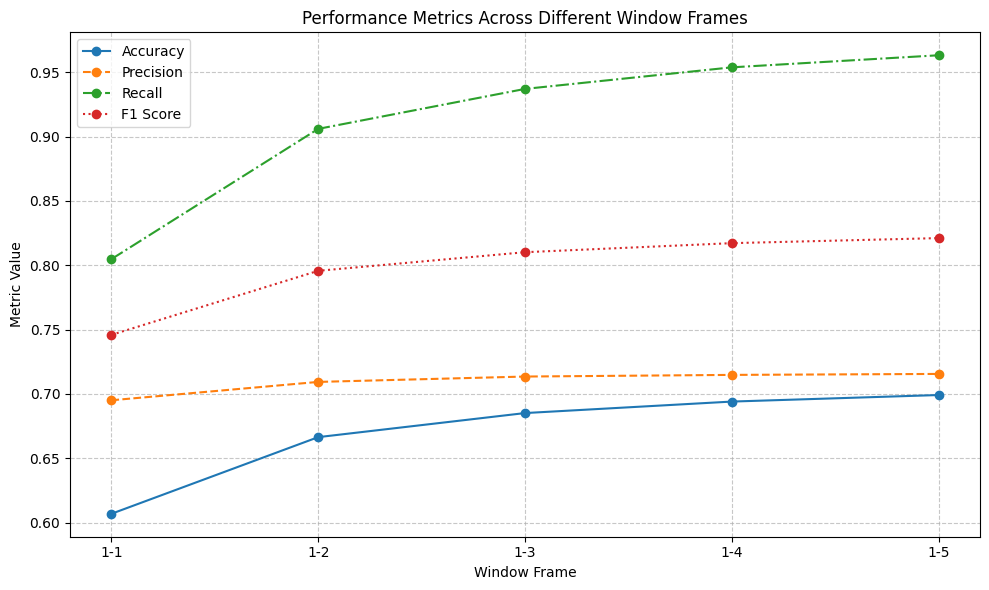

In [ ]:
# import matplotlib.pyplot as plt

# Extract data for plotting
window_frames = metrics_df['Window Frame']
accuracy = metrics_df['Accuracy']
precision = metrics_df['Precision']
recall = metrics_df['Recall']
f1_score = metrics_df['F1 Score']

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot each metric
plt.plot(window_frames, accuracy, label='Accuracy', marker='o', linestyle='-')
plt.plot(window_frames, precision, label='Precision', marker='o', linestyle='--')
plt.plot(window_frames, recall, label='Recall', marker='o', linestyle='-.')
plt.plot(window_frames, f1_score, label='F1 Score', marker='o', linestyle=':')

# Add title and labels
plt.title('Performance Metrics Across Different Window Frames')
plt.xlabel('Window Frame')
plt.ylabel('Metric Value')

# Add legend
plt.legend()

# Display grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import recall_score, f1_score, accuracy_score

# List of window frames to evaluate
window_frames = ['1-1', '1-2', '1-3', '1-4', '1-5']
file_paths = [
    '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM1.xlsx',
    '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM2.xlsx',
    '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM3.xlsx',
    '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM4.xlsx',
    '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM5.xlsx'
]

# Initialize lists to store metrics for Medina
metrics_data_medina = []

def compute_metrics_medina(df):
    """
    Compute accuracy, precision, recall, and F1-score for Medina predictions.
    Precision for Medina is calculated as:
    Precision = (True Positives for Medina) / (True Positives for Medina + False Positives for Medina)
    """
    # Filter for Medina and Mecca only
    actual_medina = df['Actual Period'] == 'Medina'
    predicted_medina = df['Predicted Period'] == 'Medina'

    # Calculate True Positives (TP) for Medina and False Positives (FP) for Medina
    true_positive_medina = (actual_medina & predicted_medina).sum()
    false_positive_medina = (~actual_medina & predicted_medina).sum()
    false_negative_medina = (actual_medina & ~predicted_medina).sum()
    true_negative_medina = (~actual_medina & ~predicted_medina).sum()

    # Precision for Medina based on the custom formula
    precision_medina = true_positive_medina / (true_positive_medina + false_positive_medina) if (true_positive_medina + false_positive_medina) > 0 else 0

    # Recall for Medina (standard recall formula)
    recall_medina = recall_score(actual_medina, predicted_medina)

    # F1 score for Medina (standard F1 score formula)
    f1_medina = f1_score(actual_medina, predicted_medina)

    # Accuracy (standard accuracy formula)
    accuracy = accuracy_score(actual_medina, predicted_medina)

    return accuracy, precision_medina, recall_medina, f1_medina

# Loop through each window frame and compute metrics for Medina
for file_path, window_frame in zip(file_paths, window_frames):
    # Load the DataFrame
    df = pd.read_excel(file_path)

    # Calculate metrics for Medina
    accuracy, precision, recall, f1 = compute_metrics_medina(df)

    # Append metrics to the list for Medina
    metrics_data_medina.append([window_frame, accuracy, precision, recall, f1])

# Create a DataFrame for the metrics for Medina
metrics_df_medina = pd.DataFrame(metrics_data_medina, columns=['Window Frame', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Save the DataFrame to an Excel file
output_file_path_medina = '/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/metrics_results_for_medina.xlsx'
metrics_df_medina.to_excel(output_file_path_medina, index=False)

# Inform the user that the file has been saved
print(f'Metrics table for Medina saved to: {output_file_path_medina}')


Metrics table for Medina saved to: /content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/metrics_results_for_medina.xlsx


In [ ]:
# # Print confusion matrix with Seaborn heatmap
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Medina', 'Medina'], yticklabels=['Not Medina', 'Medina'])
# plt.title(f'Confusion Matrix for {window_frame}')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

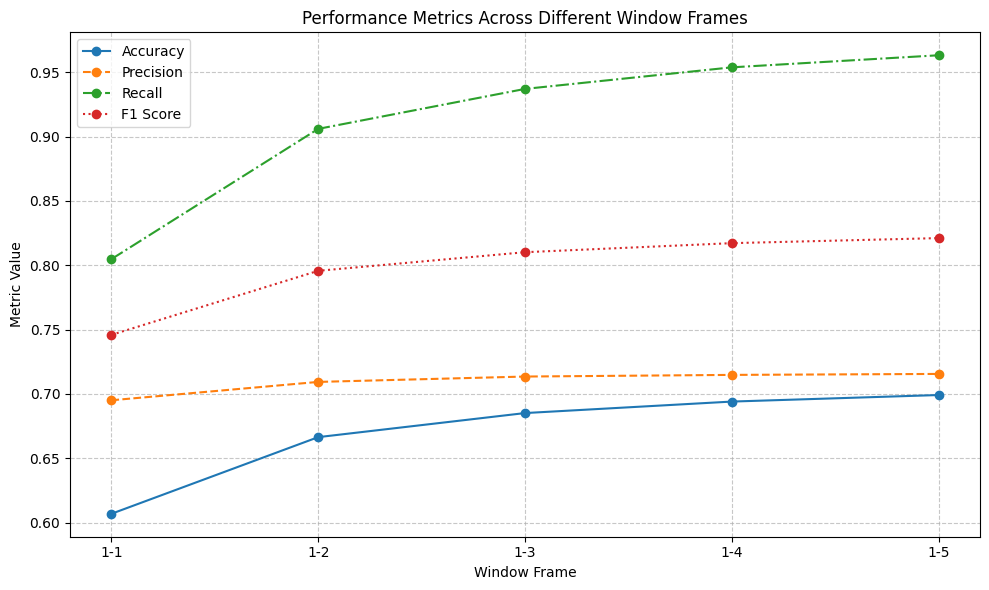

In [ ]:
# import matplotlib.pyplot as plt

# Extract data for plotting
window_frames = metrics_df['Window Frame']
accuracy = metrics_df['Accuracy']
precision = metrics_df['Precision']
recall = metrics_df['Recall']
f1_score = metrics_df['F1 Score']

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot each metric
plt.plot(window_frames, accuracy, label='Accuracy', marker='o', linestyle='-')
plt.plot(window_frames, precision, label='Precision', marker='o', linestyle='--')
plt.plot(window_frames, recall, label='Recall', marker='o', linestyle='-.')
plt.plot(window_frames, f1_score, label='F1 Score', marker='o', linestyle=':')

# Add title and labels
plt.title('Performance Metrics Across Different Window Frames')
plt.xlabel('Window Frame')
plt.ylabel('Metric Value')

# Add legend
plt.legend()

# Display grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

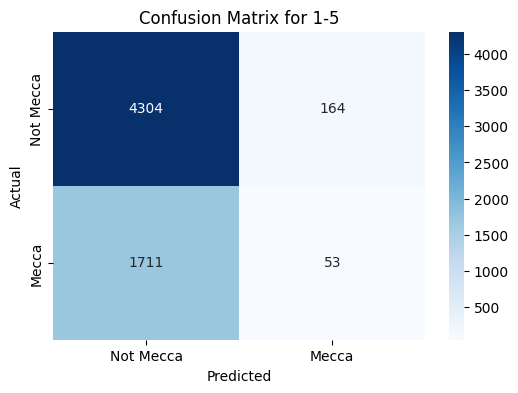

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming 'df' is your DataFrame containing 'Actual Period' and 'Predicted Period'
# Replace this with the correct DataFrame name or filtering if necessary
df = pd.read_excel('/content/drive/MyDrive/Quran-vs-biography-semantic-similarity-CSE498/DATASET of valley came alive/DFM5.xlsx')  # Example: Using the last file in your file_paths

# Filter for Mecca and Medina only (replace 'Actual Period' and 'Predicted Period' with your actual column names)
actual = df['Actual Period'].apply(lambda x: 'Mecca' if x == 'Mecca' else 'Not Mecca')
predicted = df['Predicted Period'].apply(lambda x: 'Mecca' if x == 'Mecca' else 'Not Mecca')

# Calculate the confusion matrix
cm = confusion_matrix(actual, predicted)

# Print confusion matrix with Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Mecca', 'Mecca'], yticklabels=['Not Mecca', 'Mecca'])
plt.title(f'Confusion Matrix for {window_frame}')  # Make sure window_frame is defined and available
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()